In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmap

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:

HUC8_ID_lst = [14050001, ## upper yampa
               14010001, ## roaring fork
               14020002, ## upper gunnison
               14080101, ## upper san juan
               # 14050005, ## upper white
               # 14050002, ## lower yampa
               # 14080104, ## animas (San Juans),
               # 14030002, ## upper dolores
               # 11020002, ## arkansas - Pueblo Reservoir
               # 10190005 ## St. Vrain (Boulder)
               # 14030005, ## 'Upper Colorado-Kane Springs'
               # 10190002, ## 'Upper South Platte'
               # 10190018, ## 'Lower South Platte'
               # 10190012, ## 'Middle South Platte-Sterling'
               # 11020001 ## Arkansas Headwaters
               # 11020009 ## Upper Arkansas-John Martin Reservoir
              ]

In [4]:
start_mon = 1
end_mon = 12

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
## get just Nov - April
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')

HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs

## a quick function that assigns each watershed a basin value 
## based on the first 2 numbers of the HUC8 identifier

basin_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    HUC2 = HUC8_ID[:2]
    if HUC2 == '14':
        basin = 'Upper Colorado'
    elif HUC2 == '13':
        basin = 'Rio Grande'
    elif HUC2 == '11':
        basin = 'Arkansas'
    elif HUC2 == '10':
        basin = 'Missouri'
   
    basin_lst.append(basin)
    
ds_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = path_to_data +'preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
## add the basin name as a coord
ds = ds.assign_coords({'basin': ("HUC8", basin_lst)})
ds = select_months_ds(ds, 11, 4, 'start_date')
ds


<xarray.Dataset>
Dimensions:             (index: 72, start_date: 592, HUC8: 92)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2000-01-11 ... 2023-12-26
    time                (HUC8, start_date, index) datetime64[ns] NaT NaT ... NaT
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
    basin               (HUC8) <U14 'Upper Colorado' ... 'Missouri'
Data variables: (12/21)
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    u                   (HUC8, start_date, index) float64 nan nan ... nan nan
    v                   (HUC8, start_date, index) float64 nan nan ... nan nan
    w                   (HUC8, start_date, index) float64 nan nan ... nan nan
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    tARget_strict       (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    time_match          (HUC8, start_date) object nan nan nan ... nan nan nan
    lev_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    lat_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    lon_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan

In [5]:
## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:3857") # have to manually set the projection
## set a column to be the first two numbers 
## get first two numbers of HUC8
basin_number = polys['HUC8'].values
newlist = [x[:2] for x in basin_number]
polys['basin'] = newlist
tmp = polys.dissolve(by='basin', aggfunc='sum')
tmp['basin'] = [10, 11, 13, 14]
tmp

geometry  OBJECTID  \
basin                                                                
10     POLYGON ((-105.86763 39.49419, -105.86738 39.4...      1459   
11     POLYGON ((-103.03204 36.72690, -103.03261 36.7...       984   
13     POLYGON ((-105.23421 37.03533, -105.23449 37.0...       343   
14     POLYGON ((-108.25677 36.48243, -108.25707 36.4...      1492   

                                                   TNMID MetaSource  \
basin                                                                 
10     {88F45F9F-080F-45EF-9653-CC111BD4D053}{E180B15...          0   
11     {FD7D8C74-67B1-4679-A903-413DB9337C81}{2BD36A3...          0   
13     {3C828B69-1041-4E06-98D9-546F1A0AB778}{72C226B...          0   
14     {75740F8C-AFFA-40B5-908E-4911BCB38D0B}{9CE10C9...          0   

      SourceData SourceOrig SourceFeat  \
basin                                    
10             0          0          0   
11             0          0          0   
13             0          0          0   
14             0          0          0   

                                                LoadDate  GNIS_ID  \
basin                                                               
10     2012-06-112012-06-112012-06-112012-06-112012-0...        0   
11     2016-10-112012-06-112012-06-112012-06-112012-0...        0   
13     2012-06-112012-06-112017-09-202012-06-112017-0...        0   
14     2012-06-112012-06-112012-06-112012-06-112012-0...        0   

         AreaAcres   AreaSqKm  \
basin                           
10     29440289.37  119140.77   
11     23931227.67   96846.34   
13      8975607.30   36323.02   
14     35639918.22  144229.79   

                                                  States  \
basin                                                      
10     COCOCOCO,KS,NECO,NECO,NECOCO,NE,WYCO,NECO,WYCO...   
11     COCOCO,NMCOCOCO,KS,NM,OKCOCO,NM,OKCOCO,NMCO,KS...   
13                            CO,NMCO,NMCO,NMCOCO,NMCOCO   
14     CO,NMAZ,CO,NMCOCOCOCO,WYCO,UTCOCO,UTCO,UTCO,WY...   

                                                    HUC8  \
basin                                                      
10     1019001110190013101900141025000110250005101900...   
11     1102000211020006110800011102000811020012110400...   
13     1301000513020102130100021301000413020101130100...   
14     1408010714080105140200051402000214050002140401...   

                                                    Name  Shape_Leng  \
basin                                                                  
10     BijouBeaverPawneeArikareeFrenchmanLower South ...  146.538055   
11     Upper ArkansasHuerfanoCanadian HeadwatersHorse...  102.935513   
13     ConejosRio ChamaAlamosa-TrincheraSaguacheUpper...   33.428383   
14     MancosMiddle San JuanLower GunnisonUpper Gunni...  144.552341   

       Shape_Area  basin  
basin                     
10      12.613489     10  
11       9.929023     11  
13       3.681679     13  
14      15.010810     14

In [6]:
polys

OBJECTID                                   TNMID MetaSource SourceData  \
0          1  {75740F8C-AFFA-40B5-908E-4911BCB38D0B}       None       None   
1          2  {9CE10C90-4927-4081-A2DE-D75ACBD9AB0E}       None       None   
2          3  {E2E7179D-6D0F-4ACF-834E-5D4374049550}       None       None   
3          4  {4EED71FB-EF76-4C19-AF12-20EB00933CC8}       None       None   
4          5  {86C5C83C-94D7-4D2A-8C7D-FAD6692393E9}       None       None   
..       ...                                     ...        ...        ...   
87        88  {AAFC1326-6A7C-49C0-BC17-9573AE42BC21}       None       None   
88        89  {9B76BB5C-5457-44FC-A615-03F4E1E7B6DB}       None       None   
89        90  {F03AFF73-2581-45A4-8C3B-871527565D2F}       None       None   
90        91  {056F412F-FCEA-4073-9F4D-4B9ECE0106D7}       None       None   
91        92  {71FCD77F-5433-4A4D-B57D-38B13FA4A37E}       None       None   

   SourceOrig SourceFeat    LoadDate  GNIS_ID   AreaAcres  AreaSqKm    States  \
0        None       None  2012-06-11        0   513247.49   2077.04     CO,NM   
1        None       None  2012-06-11        0  1244784.87   5037.47  AZ,CO,NM   
2        None       None  2012-06-11        0  1064098.35   4306.26        CO   
3        None       None  2012-06-11        0  1543205.42   6245.14        CO   
4        None       None  2012-06-11        0  1004494.10   4065.05        CO   
..        ...        ...         ...      ...         ...       ...       ...   
87       None       None  2016-10-11        0  1183831.16   4790.80        CO   
88       None       None  2012-06-11        0   515946.10   2087.96        CO   
89       None       None  2012-06-11        0   932953.43   3775.53     CO,KS   
90       None       None  2012-06-11        0  1471856.04   5956.40     CO,KS   
91       None       None  2012-06-11        0   411717.02   1666.16     CO,KS   

        HUC8                           Name  Shape_Leng  Shape_Area  \
0   14080107                         Mancos    2.941237    0.210751   
1   14080105                Middle San Juan    5.288235    0.509042   
2   14020005                 Lower Gunnison    4.109297    0.446387   
3   14020002                 Upper Gunnison    5.238936    0.643883   
4   14050002                    Lower Yampa    5.192248    0.431572   
..       ...                            ...         ...         ...   
87  10190002             Upper South Platte    4.288653    0.500925   
88  11020013                      Two Butte    3.865454    0.213047   
89  11030002                     Whitewoman    4.181846    0.389768   
90  11030001  Middle Arkansas-Lake McKinney    5.247919    0.611643   
91  10250013                  Little Beaver    3.796624    0.174853   

                                             geometry basin  
0   POLYGON ((-108.17534 37.49757, -108.17470 37.4...    14  
1   POLYGON ((-108.02906 37.45744, -108.02890 37.4...    14  
2   POLYGON ((-107.85652 39.07754, -107.85617 39.0...    14  
3   POLYGON ((-107.03062 38.83861, -107.03026 38.8...    14  
4   POLYGON ((-107.77363 40.76779, -107.77339 40.7...    14  
..                                                ...   ...  
87  POLYGON ((-105.04506 39.76261, -105.04449 39.7...    10  
88  POLYGON ((-102.12829 38.03786, -102.12874 38.0...    11  
89  POLYGON ((-102.35287 38.73024, -102.35176 38.7...    11  
90  POLYGON ((-102.08766 38.40768, -102.08542 38.4...    11  
91  POLYGON ((-101.19738 39.91774, -101.19727 39.9...    10  

[92 rows x 17 columns]

In [7]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

ext = [-140., -90., 20, 50]

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

titlestring = [['(a)', '(b)', '(c)', '(d)'],
               ['(e)', '(f)', '(g)', '(h)']]

epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857


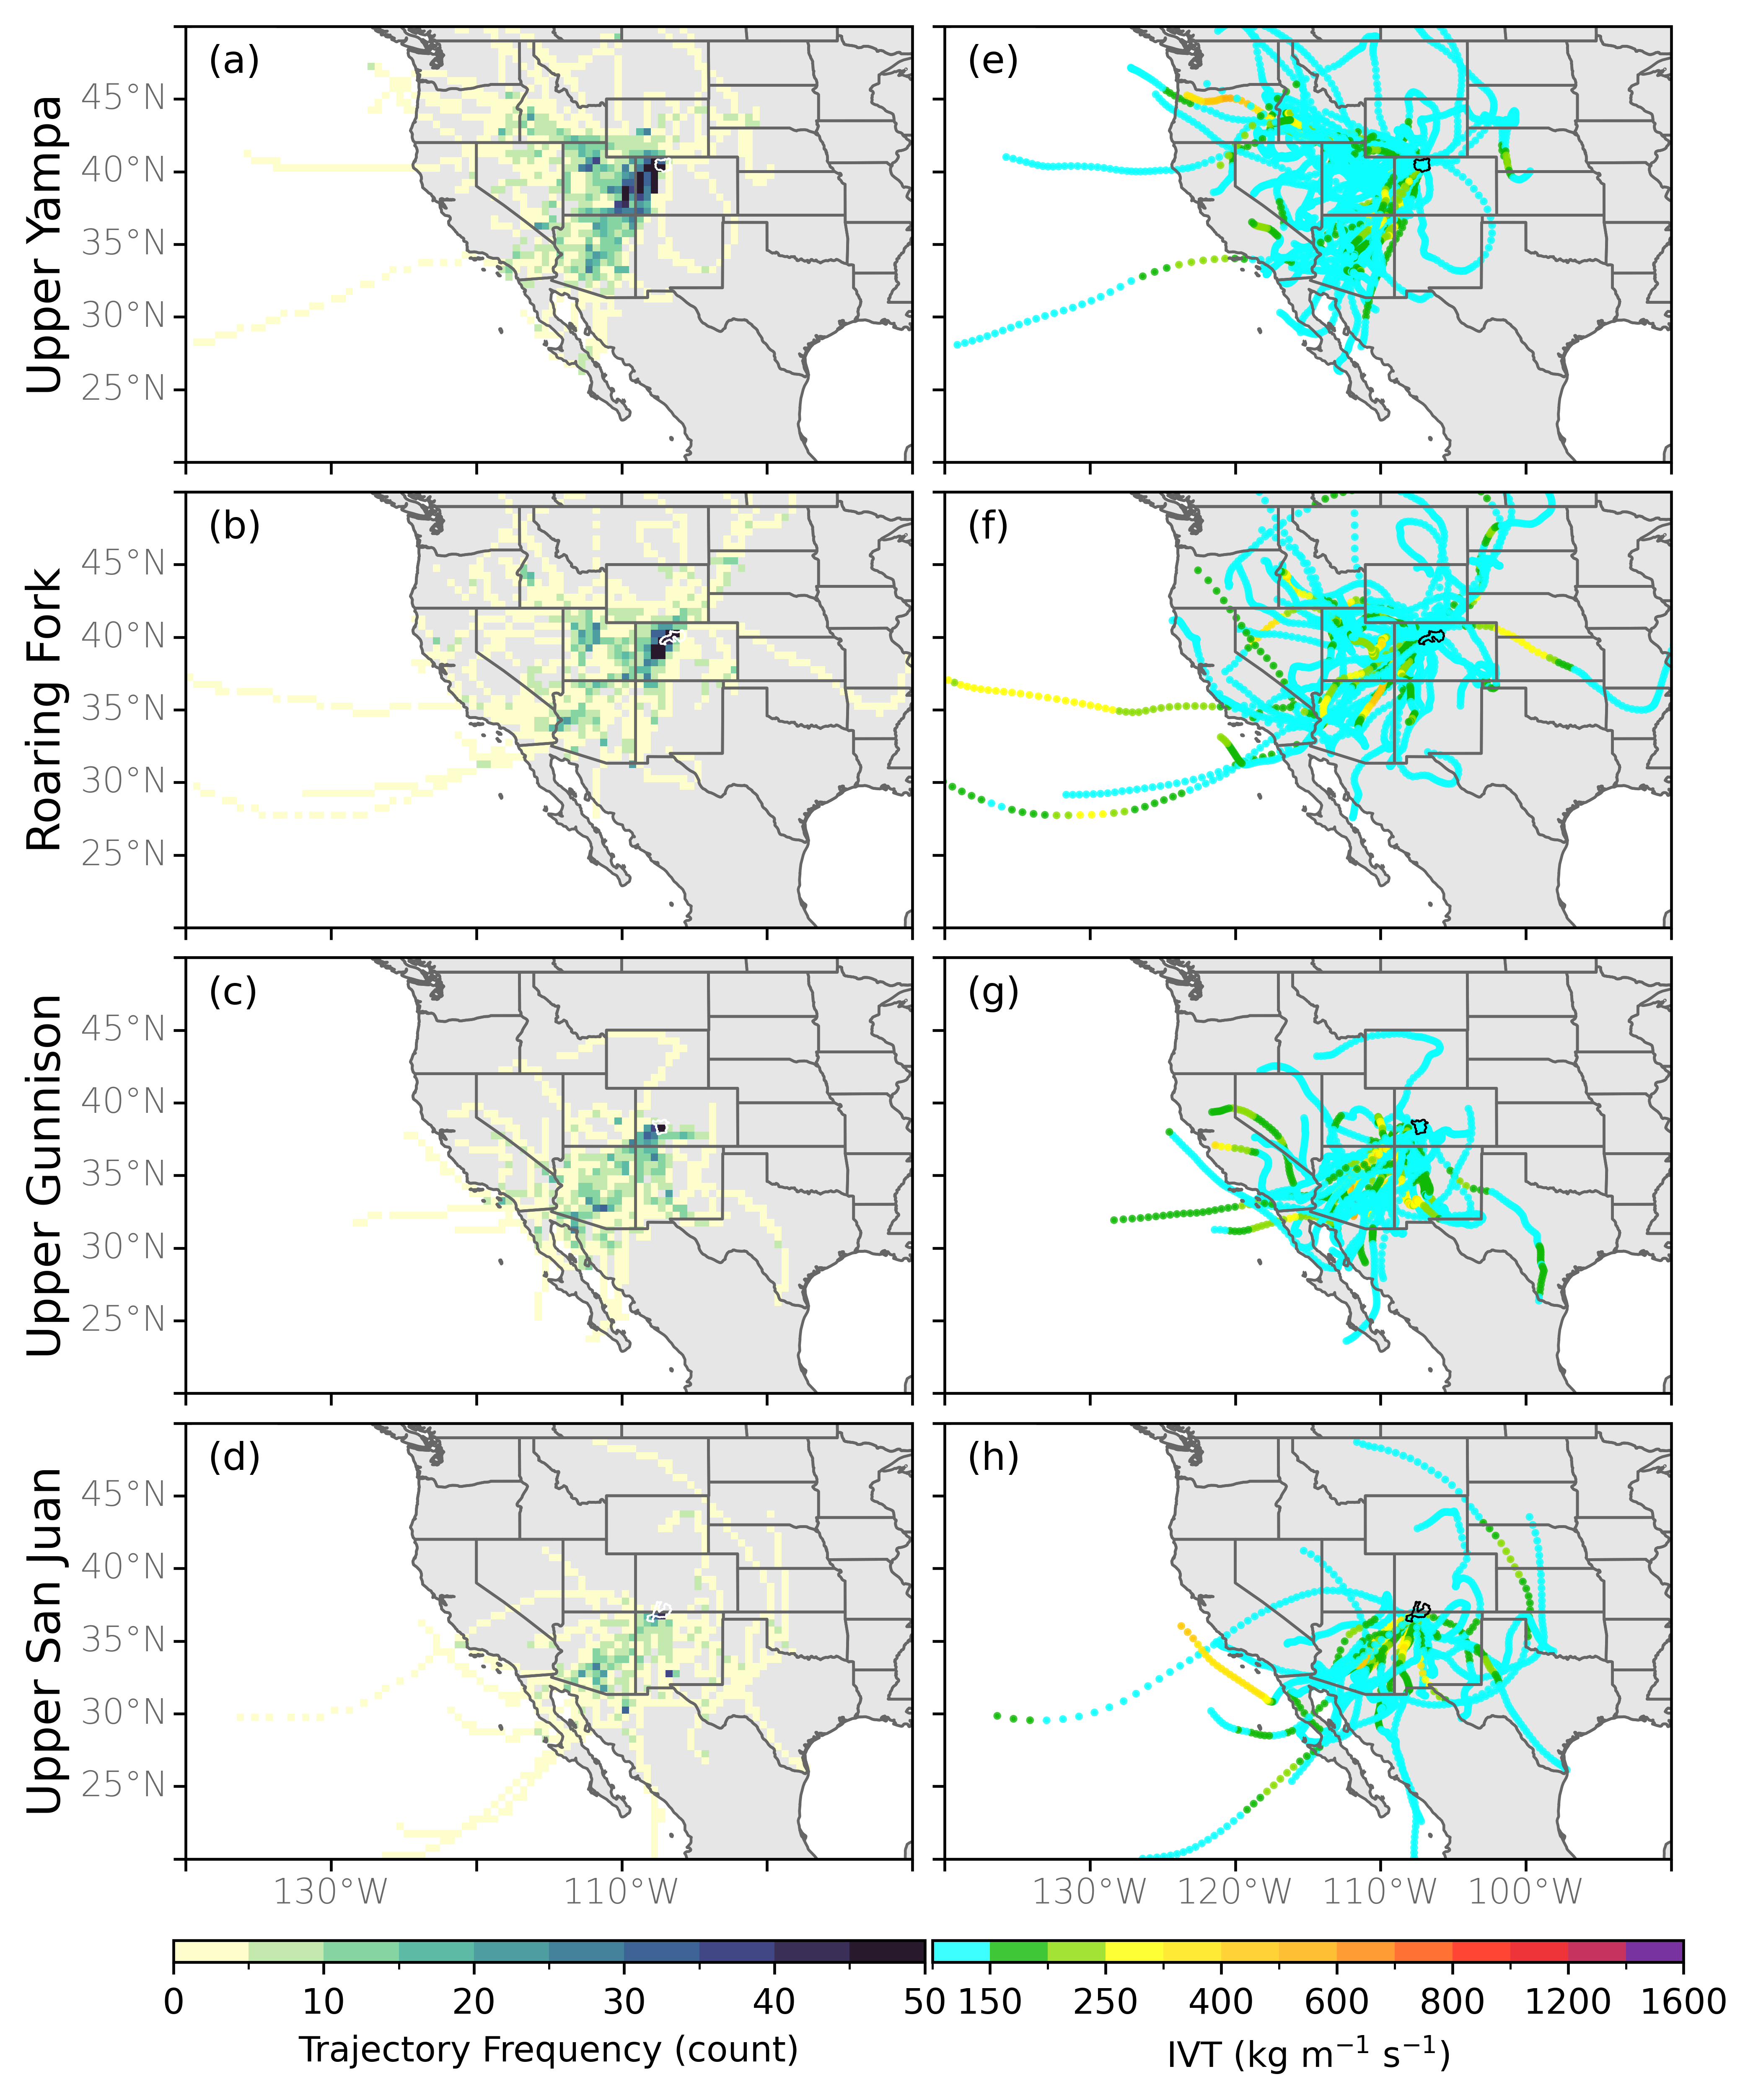

In [8]:
nrows = 6
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(7.75, 10.))
fig.dpi = 600
fname = path_to_figs + 'ARScale_trajectory-IVT_heatmaps_noAR'
fmt = 'png'

#####################
### PLOT HEATMAPS ###
#####################
basin_lst = ['Upper Yampa', 'Roaring Fork', 'Upper Gunnison', 'Upper San Juan']
# Add color bar axis
cbax = plt.subplot(gs[-1,0]) # colorbar axis

col_idx = [0, 0, 0, 0]
row_idx = [0, 1, 2, 3]
blon_lst = [False, False, False, True]
for i, HUC8 in enumerate(HUC8_ID_lst):
    ax = fig.add_subplot(gs[row_idx[i],col_idx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, 
                      right_lats=False, bottom_lons=blon_lst[i])
    
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    ax.text(-0.16, 0.5, basin_lst[i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
    tmp = ds.where(ds.HUC8==str(HUC8), drop=True).squeeze()
    AR = tmp.where(tmp.ar_scale.isnull(), drop=True)
    ## now calculate heatmaps from remaining trajectories
    cell = calculate_heatmaps_from_trajectories(AR, normalize=False, AR=False)

    ## create segmented cmap
    cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 55, 5))
    ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
    cf = cell.plot(ax=ax, column='n_traj', cmap=cmap, vmin=bnds[0], vmax=bnds[-1], norm=norm, edgecolor=None, legend=True, cax=cbax,
                  legend_kwds={"label": "Trajectory Frequency (count)", "orientation": "horizontal"})


    ## add in four focus subbasins
    plot_poly = polys[(polys.HUC8 == str(HUC8_ID_lst[i]))]
    plot_poly.crs = 'epsg:3857'
    print(plot_poly.crs)
    plot_poly.plot(ax=ax, edgecolor='white', color='None', zorder=99, lw=0.5)

    ax.text(0.03, 0.96, titlestring[0][i], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

#######################
### PLOT IVT VALUES ###
#######################
col_idx = [1, 1, 1, 1]
row_idx = [0, 1, 2, 3]
blon_lst = [False, False, False, True]
for i, HUC8 in enumerate(HUC8_ID_lst):
    ax = fig.add_subplot(gs[row_idx[i], col_idx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=False, 
                      right_lats=False, bottom_lons=blon_lst[i])
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    tmp = ds.where(ds.HUC8==str(HUC8), drop=True)
    AR = tmp.where(tmp.ar_scale.isnull(), drop=True)
    nevents = len(AR.start_date)
    ## Add different points
    for j in range(nevents):
        data = AR.isel(start_date=j)
        y_lst = data.lat.values
        x_lst = data.lon.values
        z_lst = data.IVT.values
        # ax.plot(x_lst, y_lst, c='gray', transform=datacrs, alpha=0.2)
        cmap, norm, bnds = ccmap.cmap('ivt')
        cf = ax.scatter(x_lst, y_lst, c=z_lst, cmap=cmap, norm=norm, marker='.', transform=datacrs, alpha=0.8, s=6)

    ## add in four focus subbasins
    plot_poly = polys[(polys.HUC8 == str(HUC8_ID_lst[i]))]
    plot_poly.crs = 'epsg:3857'
    print(plot_poly.crs)
    plot_poly.plot(ax=ax, edgecolor='black', color='None', zorder=99, lw=0.5)

    ax.text(0.03, 0.96, titlestring[1][i], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)


# Add color bar
cbarticks = [150, 250, 400, 600, 800, 1200, 1600]
cbax = plt.subplot(gs[-1,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=10)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857
epsg:3857


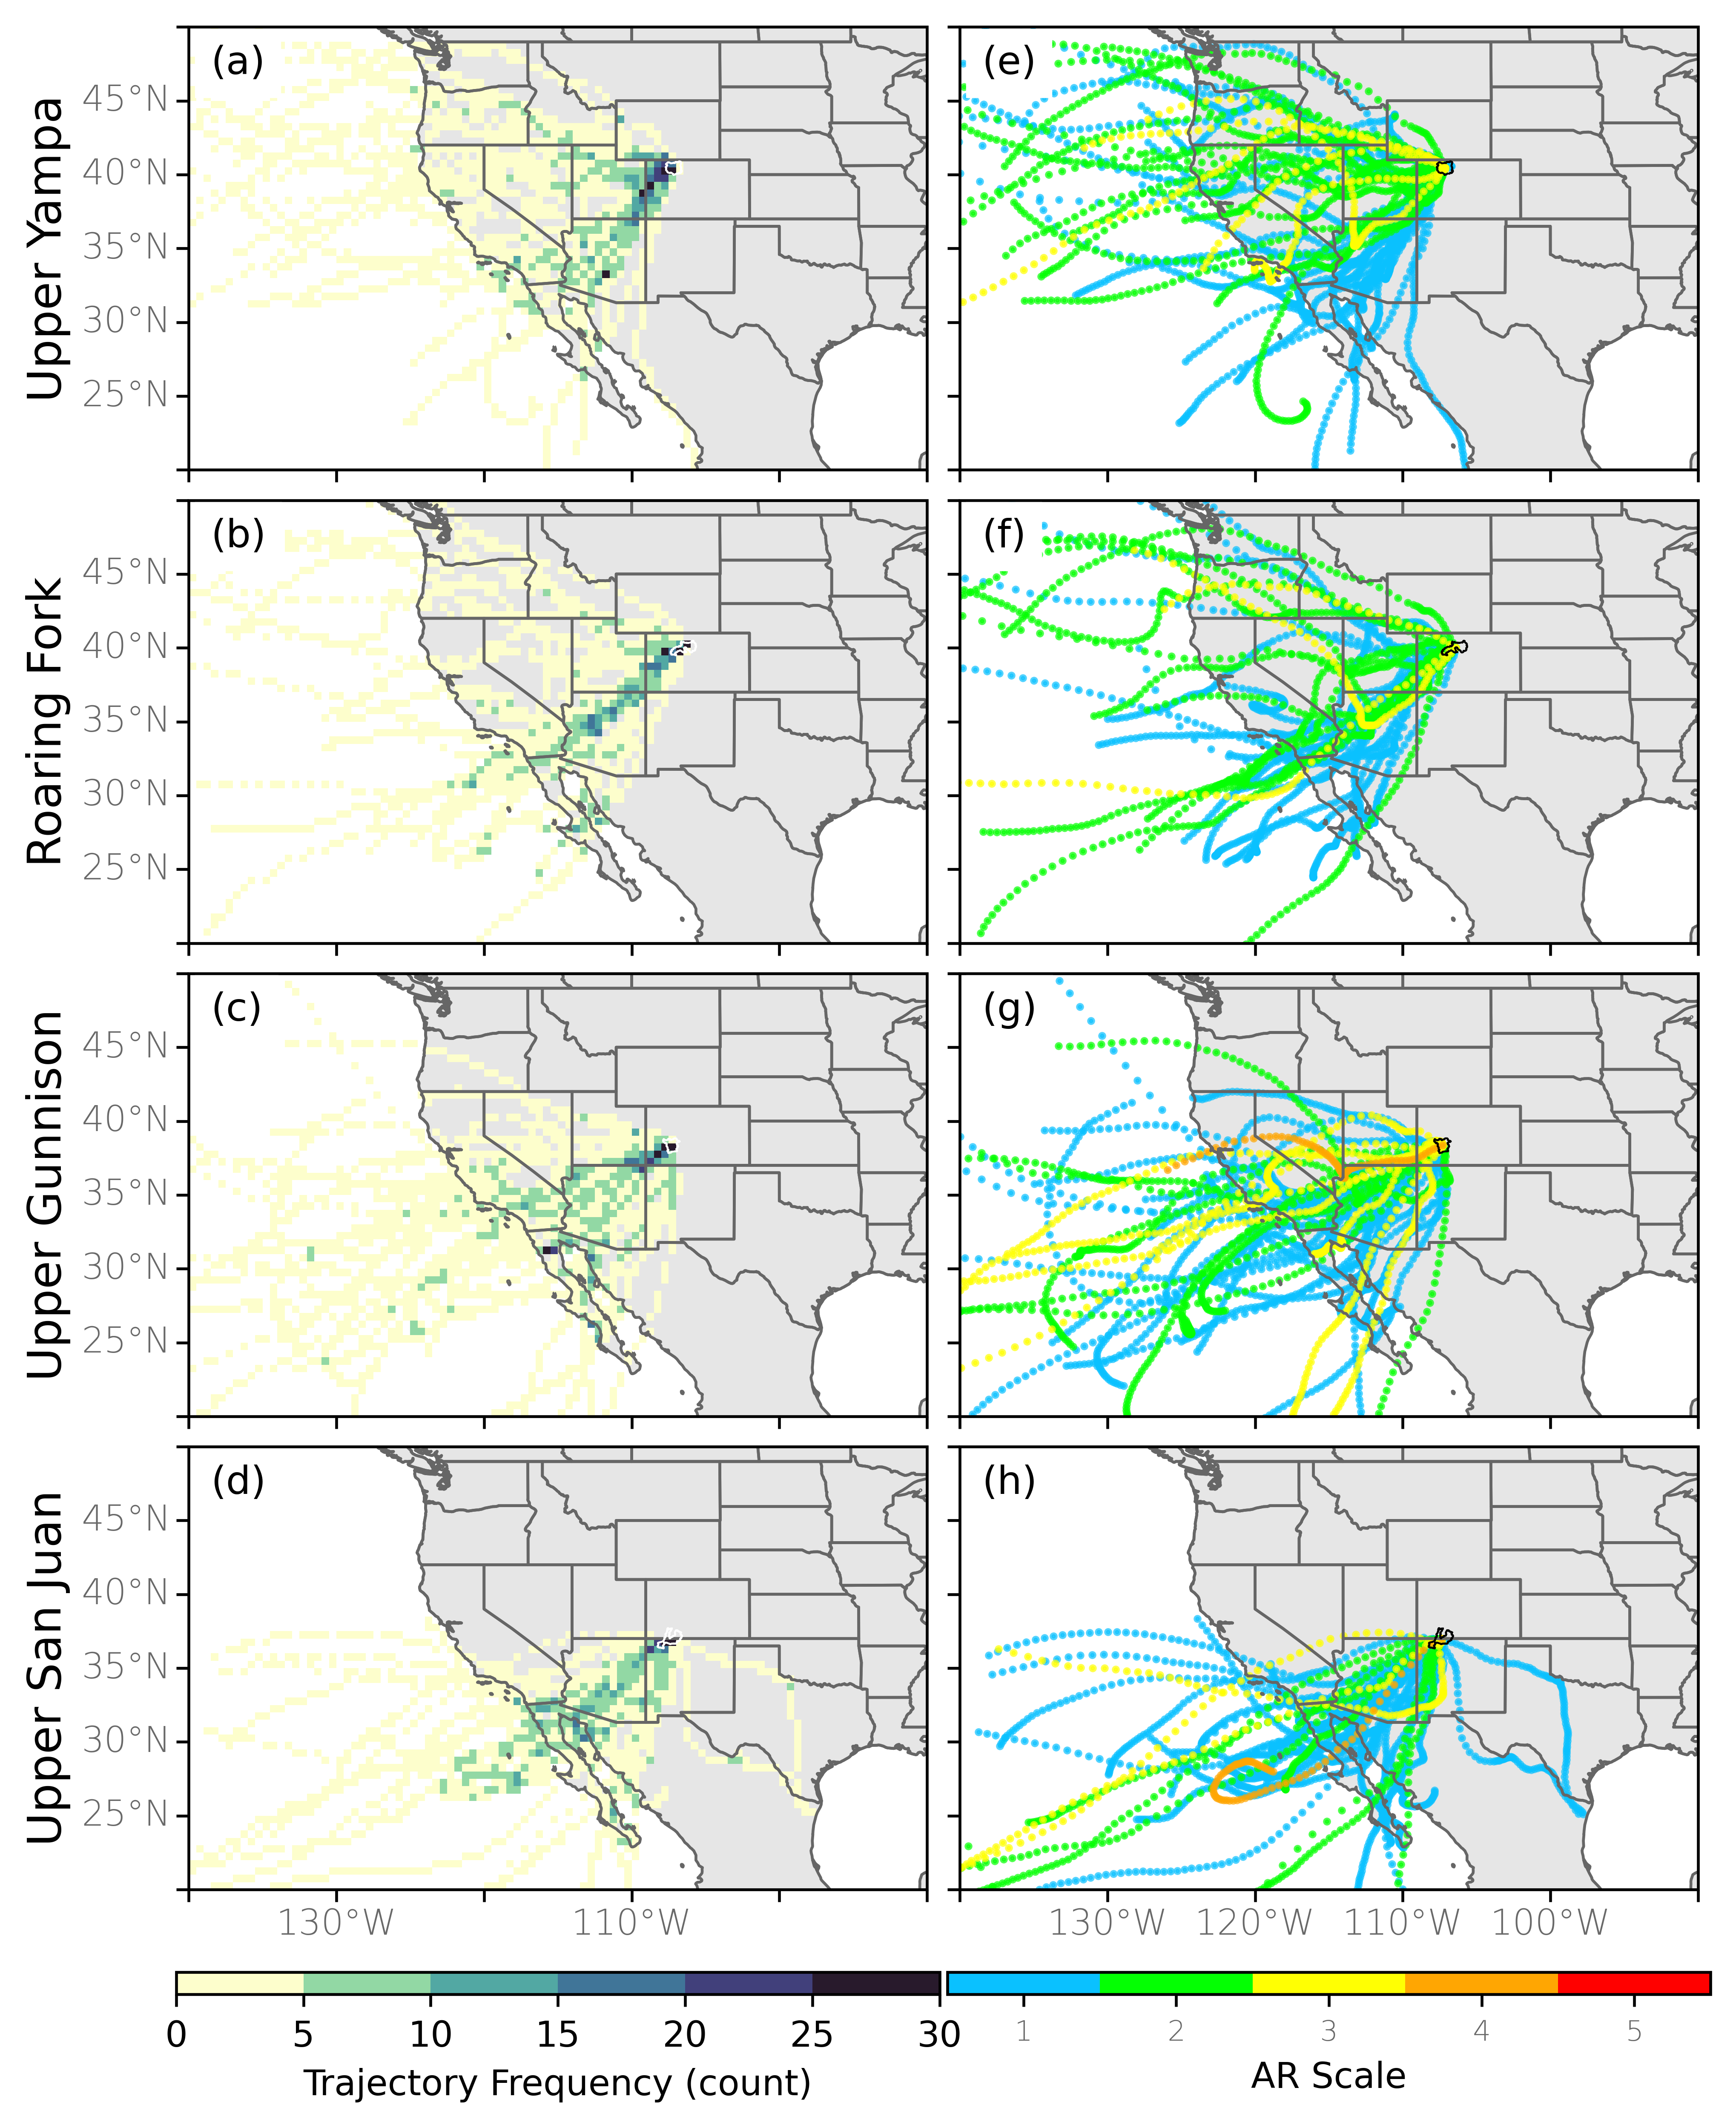

In [9]:
nrows = 6
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(7.75, 10.))
fig.dpi = 600
fname = path_to_figs + 'ARScale_trajectory_heatmaps_AR'
fmt = 'png'

#####################
### PLOT HEATMAPS ###
#####################
basin_lst = ['Upper Yampa', 'Roaring Fork', 'Upper Gunnison', 'Upper San Juan']
# Add color bar axis
cbax = plt.subplot(gs[-1,0]) # colorbar axis

col_idx = [0, 0, 0, 0]
row_idx = [0, 1, 2, 3]
blon_lst = [False, False, False, True]
for i, HUC8 in enumerate(HUC8_ID_lst):
    ax = fig.add_subplot(gs[row_idx[i],col_idx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, 
                      right_lats=False, bottom_lons=blon_lst[i])
    
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    ax.text(-0.16, 0.5, basin_lst[i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
    tmp = ds.where(ds.HUC8==str(HUC8), drop=True).squeeze()
    AR = tmp.where(tmp.ar_scale > 0, drop=True)
    ## now calculate heatmaps from remaining trajectories
    cell = calculate_heatmaps_from_trajectories(AR, normalize=False, AR=False)

    ## create segmented cmap
    cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 35, 5))
    ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
    cf = cell.plot(ax=ax, column='n_traj', cmap=cmap, vmin=bnds[0], vmax=bnds[-1], norm=norm, edgecolor=None, legend=True, cax=cbax,
                  legend_kwds={"label": "Trajectory Frequency (count)", "orientation": "horizontal"})
    
    ## add in four focus subbasins
    plot_poly = polys[(polys.HUC8 == str(HUC8_ID_lst[i]))]
    plot_poly.crs = 'epsg:3857'
    print(plot_poly.crs)
    plot_poly.plot(ax=ax, edgecolor='white', color='None', zorder=99, lw=0.5)

    ax.text(0.03, 0.96, titlestring[0][i], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

#######################
### PLOT IVT VALUES ###
#######################
colors = ['#F5F0E6', '#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
col_idx = [1, 1, 1, 1]
row_idx = [0, 1, 2, 3]
blon_lst = [False, False, False, True]
for i, HUC8 in enumerate(HUC8_ID_lst):
    ax = fig.add_subplot(gs[row_idx[i], col_idx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=False, 
                      right_lats=False, bottom_lons=blon_lst[i])
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    tmp = ds.where(ds.HUC8==str(HUC8), drop=True)
    ## Loop through AR scale values
    for k in range(1, 7):
        try:
            AR = tmp.where(tmp.ar_scale == k, drop=True)
            nevents = len(AR.start_date)
            ## LOOP THROUGH TRAJECTORIES
            for m in range(nevents):
                data = AR.isel(start_date=m)
                y_lst = data.lat.values
                x_lst = data.lon.values
                ax.plot(x_lst, y_lst, c=colors[k-1], transform=datacrs, alpha=0.2)
                cf = ax.scatter(x_lst, y_lst, c=colors[k-1], marker='.', transform=datacrs, alpha=0.7, s=6)
        except IndexError:
            pass
            
    ## add in four focus subbasins
    plot_poly = polys[(polys.HUC8 == str(HUC8_ID_lst[i]))]
    plot_poly.crs = 'epsg:3857'
    print(plot_poly.crs)
    plot_poly.plot(ax=ax, edgecolor='black', color='None', zorder=99, lw=0.5)

    ax.text(0.03, 0.96, titlestring[1][i], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)


## Add color bar
cbax = plt.subplot(gs[-1,-1]) # colorbar axis
plot_arscale_cbar(cbax, orientation='horizontal')

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()